# Handling Compositional Data

In this notebook we'll look at how failing to account for the compositional nature of geochemimcal data can provide more biased statistical estimates. We'll also show how to access the pyrolite functions for logratio transformations which allowing more robust statistical analysis of these data, and some pitfalls and challenges which exist.

First, let's look at a simple demonstration of the utilitiy of compositional data analysis at a scale where it's imminently feasible - the measurement and estimation of isotope ratios. While in larger multivariate datasets we often encounter a high relative degree of missing data (one principal hurdle of compositional data anlaysis), for this scenario we can expect low to no missingness. We'll use a synthetic dataset for demonstration purposes - but we encourage you to try it out on your own dataset!

In [1]:
import pandas as pd
import numpy as np
import pyrolite.comp
import matplotlib.pyplot as plt

def signal(columns=['18O', '17O', '16O'], size=10**4, bias = np.array([np.log(498.81), np.log(0.189)]), noise=0.025):
    df = pd.DataFrame(bias + np.random.randn(size, len(columns)-1) * noise)
    df = df.pyrocomp.inverse_ALR()
    df.columns =  ['18O', '17O', '16O']
    return df

Let's create  dataframe of oxygen isotope compositions using the signal funciton above:

In [2]:
df = signal()
df.head()

,18O,17O,16O
0,0.997633,0.000380,0.001987
1,0.997615,0.000390,0.001995
2,0.997614,0.000388,0.001997
3,0.997558,0.000400,0.002042
4,0.997766,0.000332,0.001902


For compositional data, everything is relative (thanks to the closure property), so we tend to use ratios to express differences or changes between things. However, if we make incorrect assumptions about the nature of our data, we can get some incorrect answers. Say you want to know the average ratio between $^{18}O$ and $^{16}O$, at first glance you might take an 
arithmetic mean of the ratios:

In [3]:
ratio_18_16 = df['18O'] / df['16O']

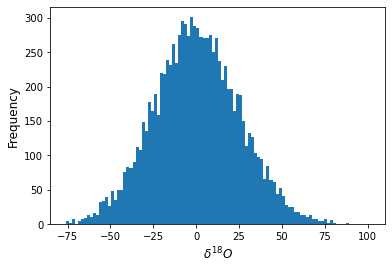

In [4]:
ax = (((ratio_18_16 /498.81)-1)*1000).plot.hist(bins=100)
ax.set(xlabel='$\delta^{18}O$');

In [5]:
mean_18_16 = ratio_18_16.mean()
mean_18_16

498.96221703341075

Equally, you could have chosen (if you ignored conventions) to take the ratio of $^{16}O$ and $^{18}O$; and you'd expect that the means are invertible - right?

In [6]:
ratio_16_18 = df['16O'] / df['18O']
mean_16_18 = ratio_16_18.mean()
mean_16_18

0.0020054060656210415

Let's see if this is the inverse of our mean from above by multiplying one by the other - expecting to get a value of exactly one:

In [7]:
mean_18_16 *  mean_16_18

1.0006218565545244

In [8]:
(mean_18_16 *  mean_16_18 - 1) * 1000

0.6218565545244026

Not quite on the mark! There is over half a permille difference between these. In reality the magnitude of this difference will be dependent on the range of values within your population; but depending on what you're looking at, this could be significant! 

So what's going on here? These peculiarities result from incorrect assumptions regarding the distribution of the data: ratios of compositional components are typically lognormally distributed, rather than normally distributed, and the compositional components themselves commonly have a Poisson distribution or similar. These distributions contrast significantly with the normal distribution at the core of most statistical tests. To some extent, part of this makes sense - the normal distribution has one immediate failure for geochemical data, in that it has non-zero probability density below 0, and we know that you can’t have negative atoms! We can compare distributions with similar expected values and variances to compare normal, lognormal and Poisson disributions (log-transformed variables below):

<img src="https://pyrolite.readthedocs.io/en/master/_images/sphx_glr_compositional_data_002.png" style="display:inline; margin: 20px 10px 10px 20px;" width="80%"/>

We can see that by taking the logarithm of the lognormal distribution we find normally distributed variable in log space. If we take the natural logarithm of the ratios before we take an average (accounting for expected log-normal distribution), and then the exponent of the mean - we can see that the situation improves:

In [9]:
logmean_18_16 = np.exp(np.log(ratio_18_16).mean())
logmean_16_18 = np.exp(np.log(ratio_16_18).mean())
logmean_18_16, 1/logmean_16_18

(498.80712448097256, 498.8071244809725)

What about uncertainties on these values?

Firstly we can look at the standard deviation relative to the arithmetic mean, and we note that again they're slightly different depending which way you look at it:

In [10]:
rstd_18_16 = ratio_18_16.std() / ratio_18_16.mean()
rstd_16_18 = ratio_16_18.std() / ratio_16_18.mean()
rstd_18_16,  rstd_16_18

(0.024943834257350722, 0.024932529480738874)

One thing to note about the uncertainties is that we expect them to be symmetric in logratio space (from the lognormal distribution), and as such, the uncertainties in ratio space should be asymmetric! Firstly, we can look at what the relative standard deviation looks like in logratio space:

In [11]:
# note that one will end up negative, as one of these ratios is below one, and following from np.log(<value below e>) < 0
logrstd_18_16 = np.log(ratio_18_16).std() / np.log(ratio_18_16).mean()
logrstd_16_18 = np.log(ratio_16_18).std() / np.log(ratio_16_18).mean() 
logrstd_18_16, logrstd_16_18 # these have the same magnitude of relative standard deviation in log space

(0.004013773570705327, -0.004013773570705327)

What does the asymmetry look like in ratio space?

In [12]:
logmean_18_16 = np.log(ratio_18_16).mean() # logmean value

d_ratio_low, ratio_mean, d_ratio_high = (
    np.exp(logmean_18_16) - np.exp(logmean_18_16 - np.log(ratio_18_16).std()),  # - 1SD
    np.exp(logmean_18_16),                                                      # mean
    np.exp(logmean_18_16 + np.log(ratio_18_16).std()) - np.exp(logmean_18_16)   # + 1SD
    )

While it's a different story for major element data, the asymmetry isn't too bad for this dataset: 

In [13]:
d_ratio_low, d_ratio_high

(12.283697537277021, 12.593835172652973)

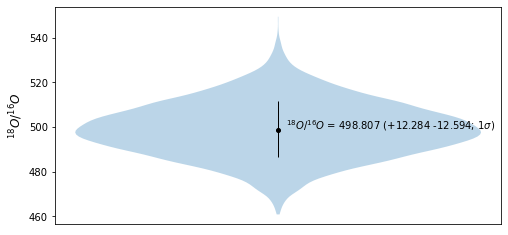

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.violinplot(ratio_18_16, [0], showmeans=False, showmedians=False, showextrema=False)
ax.errorbar([0], [ratio_mean], yerr=[[d_ratio_low], [d_ratio_high]], fmt='o', c='k')
ax.set(ylabel='$^{18}O/^{16}O$', xticks=[]);
ax.annotate("$^{18}O/^{16}O$ = " + "{:2.3f} (+{:2.3f} -{:1.3f}; 1$\sigma$)".format(ratio_mean, d_ratio_low, d_ratio_high), xy=(0.01, ratio_mean));

### Working with Some Real Data

Below we'll look at how we can use some of the compositional data functionality of `pyrolite.comp` in a data analysis and visualisation workflow. We'll be looking at some spinel geochemistry data from Norilsk, and examining the geochemical features of spinels found as inclusions within different phases. 

The data we use belowis available as supplementary material in Schoneveld, L., Barnes, S. J., Williams, M., Le Vaillant, M., and  Paterson, D., 2020, Silicate and Oxide Mineral Chemistry and Textures of the Norilsk-Talnakh Ni-Cu-Platinum Group Element Ore-Bearing Intrusions: Economic Geology doi: http://doi.org/10.5382/econgeo.4747. We can see that each major-element mineral analysis below includes relevant context as to the data source, analysis, thin section location and the enclosing phase within which the spinel sits. The anlyses include major oxdides in weight percent, and calcuated atoms per formula unit (apfu) for each of these cations:

In [15]:
#import the data
df = pd.read_csv('../data/Norilsk_spinel_major_chemistry.csv')
numerical_columns = df.select_dtypes('number').columns
df[numerical_columns] = df[numerical_columns].where(lambda x: x > 0.) # remove values below zero
df.head(2)

,Mineral,Reference,Analysis Type,Location,Site,Section,Img. Ref. No.,Enclosing Phase,Na2O_pct,MgO_pct,...,Fe2_apfu,Fe3_apfu,Mn_apfu,Mg_apfu,Co_apfu,Zn_apfu,Ni_apfu,Tot_cat,Mgno,Fe3no
0,spinel,"Barnes and Kunilov, 2000",WDS,Norilsk,Chibacheka River Intrusion,UK35-118.9,1A,olivine,NaN,4.47,...,0.766897,0.235714,0.012958,0.268278,0.001492,0.007134,0.004035,2.991597,0.259162,0.126457
1,spinel,"Barnes and Kunilov, 2000",WDS,Norilsk,Chibacheka River Intrusion,UK35-118.9,6A,olivine,NaN,5.00,...,0.713053,0.202028,0.011033,0.294224,0.000835,0.006412,0.005911,2.999275,0.292099,0.104364


What we'd like to do here is look at how the chemistry varies between spinels found in different enclosing phases - and from that point see what we can link back to the magmatic history of some of these rocks. We can see that there are five potential mineral hosts for spinel (olivine, pyroxene, plagioclase, sulfide and 'silicate'), the potential for spinels to be in bubbles and an empty data value - 'nan':

In [16]:
# list the enclosing phases of the spinel
df['Enclosing Phase'].unique()

array(['olivine', 'pyroxene', 'silicate', nan, 'plagioclase', 'sulphide',
       'bubble'], dtype=object)

Before we get into some visualisation, we can standardise some colors so that everything looks the same throughout:

In [17]:
#give each category a colour
colors = {'bubble':'grey', 'olivine':'green', 'plagioclase':'pink', 'pyroxene':'teal', 'silicate':'lightgrey', 'sulphide':'orange'}

First - we can have a look at how each group of spinels is distributed with resepctto the major spinel cations $Cr$, $Al$, and $Fe^{3+}$:

In [18]:
apfu = ['Cr_apfu','Al_apfu','Fe3_apfu'] # the columns we'd like to look at

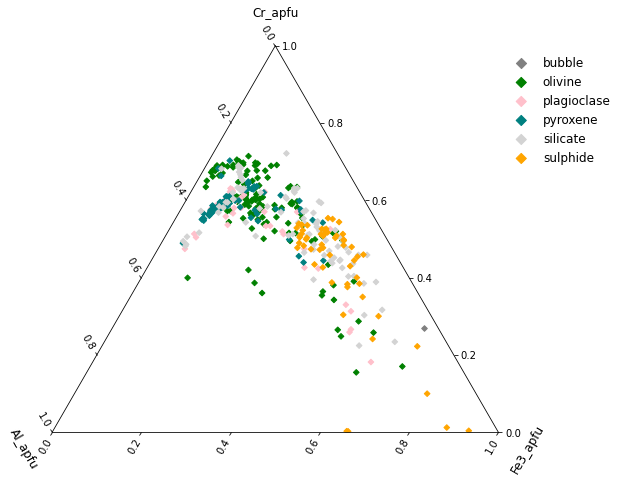

In [19]:
# for each group plot a spinel ternary diagram of the atoms per formula unit (apfu) of the trivalent cations
fig, ax = plt.subplots(1, figsize=(8, 8))

labels = []
for host, gdf in df.groupby('Enclosing Phase'):
    ax = gdf[apfu].pyroplot.scatter(c=colors[host], ax=ax)
    labels.append(host)

ax.legend(labels, fontsize=12, markerscale=1.8)

Now we'd like to plot the averages of each group on our ternary diagram, and also write these out into a separate file which we can keep handy for refrence:

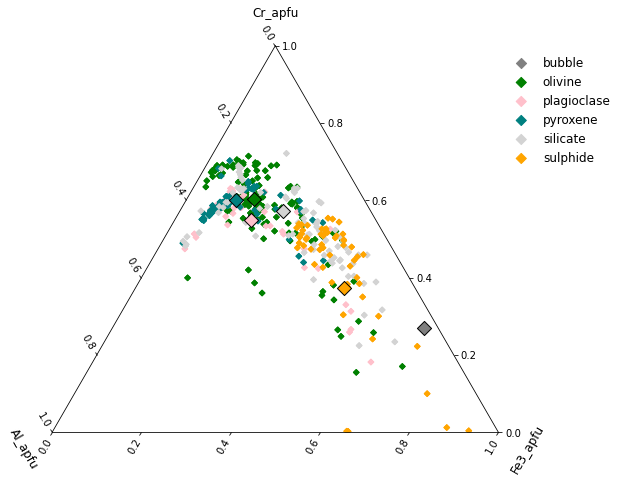

In [20]:
fig, ax = plt.subplots(1, figsize=(8, 8))

labels = []
for host, gdf in df.groupby('Enclosing Phase'):
    ax = gdf[apfu].pyroplot.scatter(c=colors[host], ax=ax) # scatter points
    labels.append(host)

ax.legend(labels, fontsize=12, markerscale=1.8)

means = {}
for host, gdf in df.groupby('Enclosing Phase'):
    ax = gdf[apfu].pyroplot.scatter(c=colors[host], ax=ax) # scatter points
    mean = gdf[apfu].dropna(how='any').pyrocomp.logratiomean()
    
    mean.pyroplot.scatter(ax=ax, 
                          facecolors=colors[host], 
                          marker='D', 
                          s=100, 
                          edgecolors="k", 
                          linewidths=1, 
                          zorder=3)
    means[host] = mean # store the mean so we can export it shortly

We now have a dictionary of means for each phase, which we can turn into a dataframe:

In [21]:
meandf = pd.DataFrame.from_records(means).T
meandf

,Cr_apfu,Al_apfu,Fe3_apfu
bubble,0.270449,0.031031,0.698520
olivine,0.603314,0.246571,0.150115
plagioclase,0.548971,0.279331,0.171699
pyroxene,0.602164,0.286139,0.111698
silicate,0.572547,0.196364,0.231089
sulphide,0.373098,0.160026,0.466876


We can easily export this to a csv file:

In [22]:
meandf.to_csv('spinel_mean_{}.csv'.format('-'.join(apfu))) # create a csv with the mean compositions which we can use later

Looks like we're most of the way there in terms of exploring the geochemical features of spinels in each of our mineral hosts - but perhaps we don't need to know the composition of every spot (some we cant' see in this diagram anyway!), and we'd just like a summary contour of the main section of the distribution. We can use `df.pyroplot.density()` to create a 68th percentile contour. 

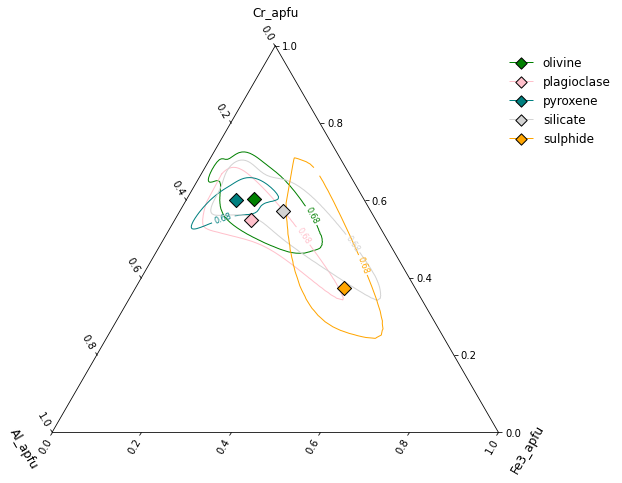

In [23]:
fig, ax = plt.subplots(1, figsize=(8, 8))

means = {}
labels = {}
for host, gdf in df.groupby('Enclosing Phase'):
    if gdf.index.size > 1: 
        # plot a contour of approximately +/- 1 sigma from the mean composition, assuming a gaussian distsribution
        ax = gdf[apfu].dropna(how='any').pyroplot.density(ax=ax, 
                                                          bins=50, 
                                                          contours=[0.68], 
                                                          colors=colors[host], 
                                                          #label_contours=False
                                                         )
        mean = gdf[apfu].dropna(how='any').pyrocomp.logratiomean()
        means[host] = mean # store the mean so we can export it shortly
        mean.pyroplot.scatter(ax=ax, 
                              facecolors=colors[host], 
                              marker='D', 
                              s=100, 
                              edgecolors="k", 
                              linewidths=1, 
                              zorder=3)
        
        
        labels[host] = tuple(ax.collections[-2:])

ax.legend(labels.values(), labels.keys(), fontsize=12, markerscale=0.8)

We can now save this figure for future reference - or to put into a manuscript. While you can use the default `matplotlib` method `fig.savefig`, `pyrolite` has a helper function which will make sure legends etc aren't cut off, and for saving in multiple formats at once:

In [24]:
from pyrolite.util.plot import save_figure
save_figure(fig, './Norilsk_spinel_chemistry_by_host', save_fmts=['pdf', 'png'])

Now that we have a workflow going, you could wrap this up into a function or two so we can use it for other mineral inclusion datasets!